In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os

In [2]:
from keras import backend as K
from keras.layers import Conv2D, Dropout, LSTM, BatchNormalization, Input,Activation, MaxPool2D, Flatten, Dense,TimeDistributed
from keras.models import Model, load_model
from keras import metrics 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
VIDEOS_DIR = './Videos/'
IMAGES_DIR = './Images/'

In [4]:
import os
classes = list(os.listdir(VIDEOS_DIR))
print(classes)

['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']


In [5]:
class_to_index = {}
for i in range(len(classes)):
    class_to_index[classes[i]] = i
class_to_index

{'Golf-Swing': 8,
 'Kicking': 0,
 'Lifting': 5,
 'Riding-Horse': 1,
 'Running': 2,
 'SkateBoarding': 3,
 'Swing-Bench': 4,
 'Swing-Side': 6,
 'Walking': 7}

In [19]:
videos = []
for x in classes:
    videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
print(videos)

[['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '004', '011', '002', '001'], ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '004', '011', '002', '008', '001'], ['003', '005', '004', '002', '001'], ['006', '003', '009', '005', '010', '007', '004', '011', '002', '008', '001'], ['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '019', '004', '011', '018', '002', '008', '001'], ['006', '003', '009', '013', '005', '012', '010', '014', '007', '004', '011', '002', '008', '001']]


In [7]:
# Using default 10 images per second
def convert_videos_to_images(video_path, image_path):
    print(video_path)
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    count = 0
    
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret == True:
            count += 1
            name = "{0:0=3d}".format(count)
            cv2.imwrite(image_path+name+'.png', frame) 
        else: 
            break

    # When everything done, release the video capture object
    cap.release()

    print(count)

In [51]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist= list(os.listdir(video_r))
        for fichier in filelist:
            if not(fichier.endswith(".avi")):
                filelist.remove(fichier)
        assert(len(filelist) == 1)
        convert_videos_to_images(video_r+filelist[0], image_r)

./Videos/Kicking/006/5117-8_70113.avi
23
./Videos/Kicking/017/RF1-16941_70021.avi
23
./Videos/Kicking/003/3833-27_70006.avi
23
./Videos/Kicking/016/6351-1_70011.avi
23
./Videos/Kicking/009/6731-2_70017.avi
22
./Videos/Kicking/013/5117-8_70350.avi
23
./Videos/Kicking/005/3949-12_70207.avi
23
./Videos/Kicking/012/3833-41_70187.avi
23
./Videos/Kicking/010/3833-15_70577.avi
23
./Videos/Kicking/015/6063-20_70333.avi
23
./Videos/Kicking/014/5863-29_70025.avi
23
./Videos/Kicking/007/6063-21_70056.avi


KeyboardInterrupt: 

In [156]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist = list(os.listdir(image_r))
        if len(filelist) <= 10:
            print(image_r)

./Images/Swing-Side/003/
./Images/Swing-Side/005/


In [6]:
def permute(X,Y):
    train_size = X.shape[0]
    permutation_train = np.random.permutation(train_size)
    X = X[permutation_train]
    Y = Y[permutation_train]
    return X,Y

In [7]:
def load_image(path,image_size):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

In [159]:
def build_dataset(image_size):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = list(os.listdir(image_r))
            #print(sorted(filelist))
            for fichier in filelist:
                if fichier.endswith(".png"):
                    image = load_image(image_r+fichier,image_size)
                    X_train_images.append(image)
                    Y_train_images.append(i)
    return permute(np.array(X_train_images), np.array(Y_train_images))

In [160]:
X_train, Y_train = build_dataset((172, 172))

In [161]:
X_train.shape

(6858, 172, 172, 3)

In [162]:
Y_train.shape

(6858,)

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

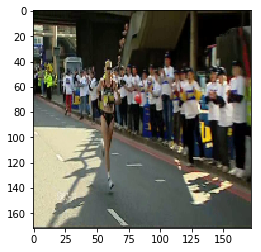

In [164]:
plt.imshow(X_train[98])

In [165]:
X_train.dtype

dtype('uint8')

In [166]:
def build_model(input_shape):
    X_input = Input(input_shape, name = "Input")
    
    X = BatchNormalization(name = 'BatchNorm_1')(X_input)
    X = Conv2D(32, (7, 7), strides = (5, 5), name="Conv_1a", padding="same")(X)
    X = Activation('relu')(X)
    
    X = Conv2D(32, (3, 3), name = "Conv_1b", padding="same")(X)
    X = Activation('relu')(X)
    X = MaxPool2D((2, 2), name = "Pool_1")(X)
    
    X = Conv2D(32, (3, 3), name ="Conv_2", padding = "same")(X)
    X = Activation('relu')(X)
    X = MaxPool2D((4, 4), name = "Pool_2")(X)
    
    X = Conv2D(8,(1,1), name='Conv_1x1')(X)
    
    X = Flatten()(X)
    
    return Model(X_input, X)

In [167]:
model = build_model((172, 172, 3))

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 35, 35, 32)        4736      
_________________________________________________________________
activation_7 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 35, 35, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 17, 17, 32)        0         
__________

In [169]:
def CNN_model(prev_model):
    X = Dense(9,activation='softmax',name='final')(prev_model.output)
    return Model(prev_model.input, X)

In [170]:
cnn = CNN_model(model)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 35, 35, 32)        4736      
_________________________________________________________________
activation_7 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 35, 35, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 17, 17, 32)        0         
__________

In [171]:
cnn.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [172]:
Y_train_one = convert_to_one_hot(Y_train, 9) 

In [173]:
cnn.fit(X_train, 
        Y_train_one, 
        batch_size=128, 
        epochs=5,
        validation_split=0.1)

Train on 6172 samples, validate on 686 samples
Epoch 1/5
6172/6172 [==============================] - 61s 10ms/step - loss: 1.1971 - acc: 0.5813 - val_loss: 0.3257 - val_acc: 0.9198
Epoch 2/5
6172/6172 [==============================] - 65s 11ms/step - loss: 0.2124 - acc: 0.9402 - val_loss: 0.0548 - val_acc: 0.9913
Epoch 3/5
6172/6172 [==============================] - 65s 10ms/step - loss: 0.0548 - acc: 0.9904 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 4/5
6172/6172 [==============================] - 66s 11ms/step - loss: 0.0151 - acc: 0.9990 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 5/5
6172/6172 [==============================] - 66s 11ms/step - loss: 0.0077 - acc: 0.9997 - val_loss: 0.0046 - val_acc: 1.0000


In [174]:
cnn.save('model_3_128_dense.h5')

### Test with LSTm

In [245]:
def rnn_model(input_shape):
    X_input = Input(input_shape)
    X = LSTM(64, return_sequences=True)(X_input)
    X = LSTM(32, return_sequences=False)(X)
    X = Dense(9,activation='softmax')(X)
    return Model(X_input, X)

In [246]:
rnn = rnn_model((170,128))

In [247]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 170, 128)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 170, 64)           49408     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 297       
Total params: 62,121
Trainable params: 62,121
Non-trainable params: 0
_________________________________________________________________


In [248]:
def model_predict(model,images):
    output = K.function([model.layers[0].input,K.learning_phase()],
                        [model.layers[11].output])
    return output([images,0])[0]

In [250]:
def pad(X_cnn,max_len):
    features_len = X_cnn.shape[1]
    length = X_cnn.shape[0]
    X_cnn = list(X_cnn)
    pad_arr = [0 for i in range(features_len)]
    for i in range(max_len-length):
        X_cnn.append(pad_arr)
    return np.array(X_cnn)    

In [251]:
def build_dataset_for_lstm(image_size):
    
    model = load_model('model_3_128_dense.h5')
    
    X_train_images = []
    Y_train_images = []
    pad_len = 170
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            
            X_cnn = model_predict(model,np.array(X_train_images_class))
            X_cnn = pad(X_cnn,pad_len) # Pad till 170 frames
            X_train_images.append(X_cnn)
            assert(X_train_images[0].shape == (170,128))
            Y_train_images.append(i)    
            
            print("Processed",videos[i][j],"of","class",classes[i])
    return X_train_images,Y_train_images       

In [214]:
X,Y = build_dataset_for_lstm((172,172))

Processed 006 of class Kicking
Processed 017 of class Kicking
Processed 003 of class Kicking
Processed 016 of class Kicking
Processed 009 of class Kicking
Processed 013 of class Kicking
Processed 005 of class Kicking
Processed 012 of class Kicking
Processed 010 of class Kicking
Processed 015 of class Kicking
Processed 014 of class Kicking
Processed 007 of class Kicking
Processed 004 of class Kicking
Processed 011 of class Kicking
Processed 002 of class Kicking
Processed 001 of class Kicking
Processed 006 of class Riding-Horse
Processed 003 of class Riding-Horse
Processed 009 of class Riding-Horse
Processed 005 of class Riding-Horse
Processed 010 of class Riding-Horse
Processed 007 of class Riding-Horse
Processed 004 of class Riding-Horse
Processed 002 of class Riding-Horse
Processed 008 of class Riding-Horse
Processed 001 of class Riding-Horse
Processed 006 of class Running
Processed 009 of class Running
Processed 005 of class Running
Processed 010 of class Running
Processed 007 of cla

In [226]:
X = np.array(X)
Y = convert_to_one_hot(np.array(Y),9)
print("Shape X",X.shape)
print("Shape Y",Y.shape)

Shape X (111, 170, 128)
Shape Y (111, 9)


## RNN Model Start

In [252]:
rnn.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [253]:
X_train_rnn,Y_train_rnn = permute(X,Y)
#X_train_rnn,X_test_rnn,Y_train_rnn,Y_test_rnn = test_train_split(X,Y)

In [254]:
rnn.fit(X_train_rnn, Y_train_rnn, epochs=10, batch_size = X_train_rnn.shape[0], validation_split=0.1)

Train on 99 samples, validate on 12 samples
Epoch 1/10
99/99 [==============================] - 3s 28ms/step - loss: 2.1978 - acc: 0.2121 - val_loss: 2.1981 - val_acc: 0.0000e+00
Epoch 2/10
99/99 [==============================] - 0s 2ms/step - loss: 2.1953 - acc: 0.1616 - val_loss: 2.1990 - val_acc: 0.0000e+00
Epoch 3/10
99/99 [==============================] - 0s 2ms/step - loss: 2.1929 - acc: 0.1717 - val_loss: 2.2000 - val_acc: 0.0000e+00
Epoch 4/10
99/99 [==============================] - 0s 2ms/step - loss: 2.1905 - acc: 0.1717 - val_loss: 2.2011 - val_acc: 0.0000e+00
Epoch 5/10
99/99 [==============================] - 0s 2ms/step - loss: 2.1880 - acc: 0.1717 - val_loss: 2.2022 - val_acc: 0.0000e+00
Epoch 6/10
99/99 [==============================] - 0s 2ms/step - loss: 2.1852 - acc: 0.1717 - val_loss: 2.2035 - val_acc: 0.0000e+00
Epoch 7/10
99/99 [==============================] - 0s 3ms/step - loss: 2.1821 - acc: 0.1717 - val_loss: 2.2050 - val_acc: 0.0000e+00
Epoch 8/10
99/99 

### END TO END

In [37]:
def end_to_end(input_shape):
    X_input = Input(input_shape)
    X = TimeDistributed(BatchNormalization(name = 'BatchNorm_1'))(X_input)
    X = TimeDistributed(Conv2D(32, (7, 7), strides = (5, 5), name="Conv_1a", padding="same"))(X)
    X = TimeDistributed(Activation('relu'))(X)
    
    X = TimeDistributed(Conv2D(32, (3, 3), name = "Conv_1b", padding="same"))(X)
    X = TimeDistributed(Activation('relu'))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_1"))(X)
    
    X = TimeDistributed(Conv2D(32, (3, 3), name ="Conv_2", padding = "same"))(X)
    X = TimeDistributed(Activation('relu'))(X)
    X = TimeDistributed(MaxPool2D((4, 4), name = "Pool_2"))(X)
    
    X = TimeDistributed(Conv2D(4,(1,1), name='Conv_1x1'))(X)
    
    X = TimeDistributed(Flatten())(X)
    
    X = LSTM(32, return_sequences=True)(X)
    X = LSTM(32, return_sequences=False)(X)
    X = Dense(9, activation='softmax')(X)
    
    return Model(X_input,X)
    

In [38]:
e2e = end_to_end((170, 172, 172, 3))

In [39]:
e2e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 170, 172, 172, 3)  0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 170, 172, 172, 3)  12        
_________________________________________________________________
time_distributed_24 (TimeDis (None, 170, 35, 35, 32)   4736      
_________________________________________________________________
time_distributed_25 (TimeDis (None, 170, 35, 35, 32)   0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 170, 35, 35, 32)   9248      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 170, 35, 35, 32)   0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 170, 17, 17, 32)   0         
__________

In [40]:
def pad_end_to_end(X_train_images_class,pad_len):
    length = X_train_images_class.shape[0]
    pad_arr = np.zeros((X_train_images_class.shape[1:4]),dtype=np.uint8)
    X_train_images_class = list(X_train_images_class)
    for i in range(pad_len-length):
        X_train_images_class.append(pad_arr)
    return np.array(X_train_images_class,dtype=np.uint8)

In [15]:
a = np.array([[1],[1]],dtype=np.uint8)
x = pad_end_to_end(a,5)
print(x.dtype)

uint8


In [27]:
def build_dataset_end_to_end(image_size, pad_len = 170):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            X_train_images_class = pad_end_to_end(np.array(X_train_images_class,dtype=np.uint8),pad_len) # Pad till 170 frames
            assert(X_train_images_class.shape == (170,172, 172, 3))
            X_train_images.append(X_train_images_class)
            Y_train_images.append(i)    
            print("Processed",videos[i][j],"of","class",classes[i])
    return np.array(X_train_images,dtype=np.uint8),np.array(Y_train_images,dtype=np.uint8)

In [28]:
X,Y = build_dataset_end_to_end((172, 172))

Processed 006 of class Kicking
Processed 017 of class Kicking
Processed 003 of class Kicking
Processed 016 of class Kicking
Processed 009 of class Kicking
Processed 013 of class Kicking
Processed 005 of class Kicking
Processed 012 of class Kicking
Processed 010 of class Kicking
Processed 015 of class Kicking
Processed 014 of class Kicking
Processed 007 of class Kicking
Processed 004 of class Kicking
Processed 011 of class Kicking
Processed 002 of class Kicking
Processed 001 of class Kicking
Processed 006 of class Riding-Horse
Processed 003 of class Riding-Horse
Processed 009 of class Riding-Horse
Processed 005 of class Riding-Horse
Processed 010 of class Riding-Horse
Processed 007 of class Riding-Horse
Processed 004 of class Riding-Horse
Processed 002 of class Riding-Horse
Processed 008 of class Riding-Horse
Processed 001 of class Riding-Horse
Processed 006 of class Running
Processed 009 of class Running
Processed 005 of class Running
Processed 010 of class Running
Processed 007 of cla

In [30]:
Y = convert_to_one_hot(Y,9)
print(X.shape)
print(Y.shape)

(111, 170, 172, 172, 3)
(111, 9)


In [41]:
e2e.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [34]:
X_train_e2e,Y_train_e2e = permute(X,Y)

In [43]:
e2e.fit(X_train_e2e, Y_train_e2e, epochs=5, batch_size = 16, validation_split=0.05)

Train on 105 samples, validate on 6 samples
Epoch 1/5
105/105 [==============================] - 183s 2s/step - loss: 2.1602 - acc: 0.1524 - val_loss: 2.2254 - val_acc: 0.0000e+00
Epoch 2/5
105/105 [==============================] - 188s 2s/step - loss: 2.1568 - acc: 0.1810 - val_loss: 2.2610 - val_acc: 0.0000e+00
Epoch 3/5
105/105 [==============================] - 177s 2s/step - loss: 2.1478 - acc: 0.1810 - val_loss: 2.1901 - val_acc: 0.0000e+00
Epoch 4/5
105/105 [==============================] - 191s 2s/step - loss: 2.1417 - acc: 0.1810 - val_loss: 2.1716 - val_acc: 0.0000e+00
Epoch 5/5
105/105 [==============================] - 180s 2s/step - loss: 2.1377 - acc: 0.1810 - val_loss: 2.2136 - val_acc: 0.0000e+00
